# Import Library

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Data Loading

Langkah ini bertujuan untuk memuat dataset yang diperlukan untuk membangun sistem rekomendasi.

In [39]:
# Path dataset yang sudah kamu upload ke Colab
file_path = '/content/ramen-ratings.csv'

In [40]:
# Membaca dataset CSV menggunakan pandas
df = pd.read_csv(file_path)

In [41]:
# Menampilkan ukuran dataset dan 5 baris pertama sebagai gambaran awal
print("Ukuran dataset:", df.shape)
print(df.head())

Ukuran dataset: (2580, 7)
   Review #           Brand  \
0      2580       New Touch   
1      2579        Just Way   
2      2578          Nissin   
3      2577         Wei Lih   
4      2576  Ching's Secret   

                                             Variety Style Country Stars  \
0                          T's Restaurant Tantanmen    Cup   Japan  3.75   
1  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...  Pack  Taiwan     1   
2                      Cup Noodles Chicken Vegetable   Cup     USA  2.25   
3                      GGE Ramen Snack Tomato Flavor  Pack  Taiwan  2.75   
4                                    Singapore Curry  Pack   India  3.75   

  Top Ten  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  


#  Data Understanding.

Pada tahap ini awal dalam proses analisis data yang bertujuan untuk mengenal dan memahami struktur, tipe, serta kualitas data ramen yang digunakan dalam penelitian. Pada tahap ini, dilakukan pemeriksaan terhadap jumlah data, tipe variabel, serta kelengkapan data termasuk pengecekan nilai yang hilang (missing values).

In [ ]:
# Menampilkan info struktur dataset (tipe data dan non-null count)
print("Info dataset:")
print(df.info())

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB
None


In [42]:
# Menampilkan statistik deskriptif untuk kolom numerik dan kategori
print("\nStatistik deskriptif:")
print(df.describe(include='all'))


Statistik deskriptif:
           Review #   Brand  Variety Style Country Stars Top Ten
count   2580.000000    2580     2580  2578    2580  2580      41
unique          NaN     355     2413     7      38    51      38
top             NaN  Nissin  Chicken  Pack   Japan     4      \n
freq            NaN     381        7  1531     352   384       4
mean    1290.500000     NaN      NaN   NaN     NaN   NaN     NaN
std      744.926171     NaN      NaN   NaN     NaN   NaN     NaN
min        1.000000     NaN      NaN   NaN     NaN   NaN     NaN
25%      645.750000     NaN      NaN   NaN     NaN   NaN     NaN
50%     1290.500000     NaN      NaN   NaN     NaN   NaN     NaN
75%     1935.250000     NaN      NaN   NaN     NaN   NaN     NaN
max     2580.000000     NaN      NaN   NaN     NaN   NaN     NaN


In [43]:
# Cek missing value di tiap kolom
print("\nJumlah missing values per kolom:")
print(df.isnull().sum())


Jumlah missing values per kolom:
Review #       0
Brand          0
Variety        0
Style          2
Country        0
Stars          0
Top Ten     2539
dtype: int64


# Exploratory Data Analysis (EDA)

 Melalui tahap ini, dilakukan analisis distribusi rating (Stars) untuk mengetahui sebaran preferensi pengguna terhadap produk ramen. Selain itu, dilakukan identifikasi brand-brand dengan rata-rata rating tertinggi guna memberikan gambaran merek mana yang memiliki kualitas unggul menurut data rating.karakteristik dan pola dalam dataset

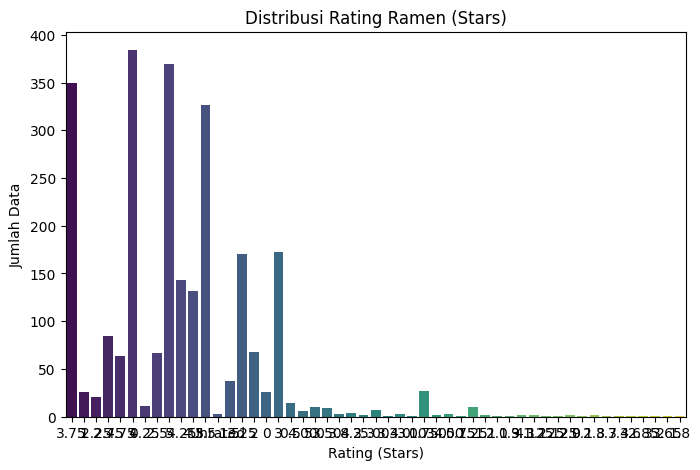

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribusi rating (Stars)
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Stars', palette='viridis')
plt.title('Distribusi Rating Ramen (Stars)')
plt.xlabel('Rating (Stars)')
plt.ylabel('Jumlah Data')
plt.show()

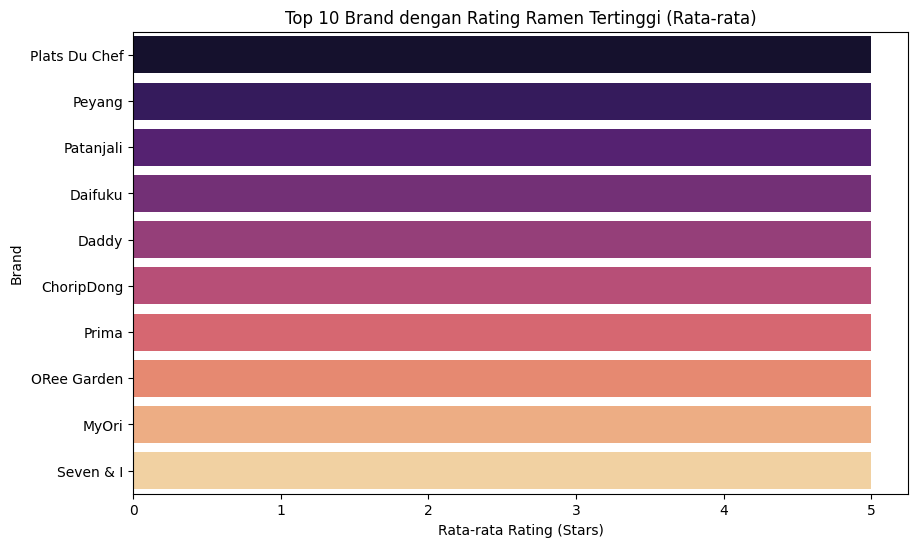

In [49]:
# Rating rata-rata per Brand (top 10 brand dengan rating tertinggi)
avg_rating_brand = df.groupby('Brand')['Stars'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_rating_brand.values, y=avg_rating_brand.index, palette='magma')
plt.title('Top 10 Brand dengan Rating Ramen Tertinggi (Rata-rata)')
plt.xlabel('Rata-rata Rating (Stars)')
plt.ylabel('Brand')
plt.show()


In [ ]:
print("Top 10 Brand dengan Rating Tertinggi:")
print(avg_rating_brand)

Top 10 Brand dengan Rating Tertinggi:
Brand
Plats Du Chef    5.0
Peyang           5.0
Patanjali        5.0
Daifuku          5.0
Daddy            5.0
ChoripDong       5.0
Prima            5.0
ORee Garden      5.0
MyOri            5.0
Seven & I        5.0
Name: Stars, dtype: float64


# Data Preparation

Tahap Data Preparation ini memastikan dataset dalam kondisi bersih, lengkap, dan sesuai dengan kebutuhan algoritma rekomendasi yang akan digunakan pada tahap berikutnya, baik content-based maupun collaborative filtering.

In [47]:
df = df.drop(columns=['Top Ten'])
print("Kolom 'Top Ten' sudah dihapus.")

Kolom 'Top Ten' sudah dihapus.


In [48]:
# Ubah 'Stars' ke numeric, dengan errors='coerce' agar nilai yang tidak bisa diubah jadi NaN
df['Stars'] = pd.to_numeric(df['Stars'], errors='coerce')

# Isi missing di kolom 'Style' dengan 'Unknown'
df['Style'] = df['Style'].fillna('Unknown')

# Cek kembali jumlah missing setelah perubahan
print("Missing values setelah preprocessing:")
print(df.isnull().sum())


Missing values setelah preprocessing:
Review #    0
Brand       0
Variety     0
Style       0
Country     0
Stars       3
dtype: int64


In [ ]:
# Buang baris dengan nilai Stars yang kosong
df = df.dropna(subset=['Stars'])

# Cek kembali ukuran data setelah drop
print("Ukuran data setelah menghapus baris tanpa rating:", df.shape)


Ukuran data setelah menghapus baris tanpa rating: (2577, 7)


In [ ]:
# Pastikan Stars sudah numeric dan tidak ada missing
print("Jumlah missing values pada Stars:", df['Stars'].isnull().sum())

Jumlah missing values pada Stars: 0


In [ ]:
# Isi missing value kolom 'Country' jika ada
df['Country'] = df['Country'].fillna('Unknown')

In [ ]:
# Cek kolom 'Country' sebagai proxy user
print("Jumlah data unik Country (sebagai user):", df['Country'].nunique())

Jumlah data unik Country (sebagai user): 38


In [ ]:
# Contoh tampilkan beberapa data
print(df[['Country', 'Brand', 'Variety', 'Stars']].head())

  Country           Brand                                            Variety  \
0   Japan       New Touch                          T's Restaurant Tantanmen    
1  Taiwan        Just Way  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...   
2     USA          Nissin                      Cup Noodles Chicken Vegetable   
3  Taiwan         Wei Lih                      GGE Ramen Snack Tomato Flavor   
4   India  Ching's Secret                                    Singapore Curry   

   Stars  
0   3.75  
1   1.00  
2   2.25  
3   2.75  
4   3.75  


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Variety'])

print("Shape TF-IDF matrix:", tfidf_matrix.shape)


Shape TF-IDF matrix: (2580, 1390)


# Model Development dengan Content-Based Filtering

Pada tahap Model Content-Based Filtering menggunakan TF-IDF untuk merepresentasikan teks ramen dan cosine similarity untuk mengukur kemiripan antar ramen. Fungsi rekomendasi mengembalikan 10 ramen paling mirip berdasarkan kemiripan konten, memudahkan pengguna menemukan ramen serupa tanpa data preferensi pengguna.

## Cosine Similarity

Mengukur kemiripan antar setiap pasangan ramen menggunakan matriks TF-IDF yang dihasilkan.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Hitung cosine similarity antar baris TF-IDF matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Cek ukuran matrix similarity
print("Shape cosine similarity matrix:", cosine_sim.shape)


Shape cosine similarity matrix: (2577, 2577)


# Evaluasi Content-Based Filtering
Precisionk mengukur proporsi item relevan dalam rekomendasi teratas. Dalam konteks ini, kita bisa mendefinisikan "relevan" sebagai ramen yang memiliki rating tinggi (misalnya, di atas 4 bintang).

In [56]:
def recommend_ramen_content_based(title, cosine_sim=cosine_sim, df=df):
    # Membuat indeks dari kolom 'Variety' untuk pencarian
    indices = pd.Series(df.index, index=df['Variety']).drop_duplicates()

    if title not in indices:
        return f"Ramen dengan nama '{title}' tidak ditemukan dalam data."

    # Ambil indeks. Jika indices[title] mengembalikan Series (karena duplikasi nama), ambil indeks pertama.
    idx = indices[title]
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0] # Ambil indeks pertama jika multiple matches

    # Ambil baris similarity untuk ramen ini, pastikan 1D array
    sim_scores_array = cosine_sim[idx]

    # Kalau sim_scores_array bentuknya 2D, flatten dulu
    if sim_scores_array.ndim > 1:
        sim_scores_array = sim_scores_array.flatten()

    # Buat list tuple (index, similarity_score)
    sim_scores = list(enumerate(sim_scores_array))

    # Sort berdasarkan similarity descending, ambil 10 teratas kecuali diri sendiri
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Hapus diri sendiri (indeks idx)
    sim_scores = [x for x in sim_scores if x[0] != idx]

    # Ambil 10 teratas
    sim_scores = sim_scores[:10]

    ramen_indices = [i[0] for i in sim_scores]

    recommended = df.iloc[ramen_indices][['Brand', 'Variety', 'Style', 'Country', 'Stars']]

    return recommended.reset_index(drop=True)

# Hitung Precision@10 untuk model content-based
precision_at_10_cb = evaluate_content_based(recommend_ramen_content_based, df, k=10, relevant_threshold=4.0)
print(f"Precision10 (Content-Based Filtering): {precision_at_10_cb:.4f}")

Precision10 (Content-Based Filtering): 0.4060


## Buat Indeks Nama Ramen

In [61]:
print(df['Variety'].unique())


["T's Restaurant Tantanmen "
 'Noodles Spicy Hot Sesame Spicy Hot Sesame Guan-miao Noodles'
 'Cup Noodles Chicken Vegetable' ...
 'Hu Tiu Nam Vang ["Phnom Penh" style] Asian Style Instant\xa0Rice\xa0Noodles'
 'Oriental Style Instant Noodles' 'Tom Yum Chili Flavor']


In [62]:
print(df['Variety'].head(10))


0                            T's Restaurant Tantanmen 
1    Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...
2                        Cup Noodles Chicken Vegetable
3                        GGE Ramen Snack Tomato Flavor
4                                      Singapore Curry
5                               Kimchi song Song Ramen
6                  Spice Deli Tantan Men With Cilantro
7                                Nabeyaki Kitsune Udon
8                             Hokkaido Soy Sauce Ramen
9                The Original Spicy Stir-Fried Noodles
Name: Variety, dtype: object


In [63]:
# Membuat indeks dari kolom 'Variety' untuk pencarian
indices = pd.Series(df.index, index=df['Variety']).drop_duplicates()

# Contoh cek indeks ramen 'Shin Black'
print("Indeks ramen 'Singapore Curry':", indices['Singapore Curry'])


Indeks ramen 'Singapore Curry': 4


In [64]:
result = recommend_ramen_content_based('Singapore Curry')
print(result)


       Brand                                            Variety Style  \
0     Nissin  Fried Noodle Specialist Tom Yam Mee Goreng Fla...  Pack   
1    Wai Wai                             Tom Yum Shrimp Flavour  Pack   
2      Myojo                               Thai Tom Yam Flavour  Bowl   
3       Wang                          Rice Noodle Kimchi Flavor  Bowl   
4     Nissin                          Chow Noodles Tomato Basil  Bowl   
5  Asia Gold            Instant Noodles With Chicken Flavouring  Pack   
6     Nissin                   Pan Asian Kitchen Spicy Pad Thai  Tray   
7      Myojo                         Men Black Seafood Tonkotsu  Bowl   
8     Ko-Lee                               Instant Noodles Beef  Pack   
9    Indomie                         Mi Goreng Barbecue Chicken  Pack   

       Country  Stars  
0    Singapore   3.00  
1     Thailand   3.25  
2    Singapore   3.75  
3  South Korea   4.00  
4          USA   4.00  
5      Hungary   3.50  
6          USA   2.75  
7   

# Model Development dengan Collaborative Filtering

## Membagi data menjadi training dan testing
 kita bagi data menjadi training (80%) dan testing (20%) dengan stratified sampling berdasarkan user agar distribusi rating tetap merata.


In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Country_mod'])


## Membuat matriks user-item

Pada tahap ini, kita mengembangkan model rekomendasi dengan pendekatan Collaborative Filtering menggunakan kolom Country sebagai proxy pengguna untuk membuat matriks user-item berdasarkan rating ramen. Kemiripan antar pengguna dihitung dengan cosine similarity, lalu rekomendasi dibuat dengan memanfaatkan preferensi pengguna serupa. Pendekatan ini memungkinkan sistem memprediksi ramen yang disukai pengguna berdasarkan pola rating kolektif dalam data.

In [ ]:
# Membuat kolom modifikasi Country
country_counts = df['Country'].value_counts()
rare_countries = country_counts[country_counts < 2].index.tolist()
df['Country_mod'] = df['Country'].apply(lambda x: 'Others' if x in rare_countries else x)


In [67]:
country_counts = df['Country'].value_counts()
rare_countries = country_counts[country_counts < 2].index.tolist()
df['Country_mod'] = df['Country'].apply(lambda x: 'Others' if x in rare_countries else x)

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Country_mod'])
print("Data training shape:", train_data.shape)
print("Data testing shape:", test_data.shape)


Data training shape: (2064, 7)
Data testing shape: (516, 7)


In [ ]:
# Membuat matriks user-item dari data training
train_matrix = train_data.pivot_table(index='Country', columns='Variety', values='Stars')

print("Shape matriks training user-item:", train_matrix.shape)
train_matrix.head()


Shape matriks training user-item: (38, 1944)


Variety,"""A"" Series Artificial Hot Beef","""A"" Series Vegetarian",1 Step-1 Minute Asian Noodles Kung Pao,1 Step-1 Minute Asian Noodles Lemongrass Ginger,1 Step-1 Minute Asian Noodles Mushroom Lo Mein,1 Step-1 Minute Asian Noodles Thai Basil,1 Step-1 Minute Asian Noodles Toasted Sesame,100 Artificial Shallot Chicken,100 Artificial Spicy Beef,100 Artificial Stewed Pork Chop,...,Yummy Spicy Rice Soup With Seafood,Yuzu Sesame Sauce Udon,Zan Vegetarian Instant Noodle Series Shiitake Mushroom Flavour,Zha Wang ((Jjawang) Noodles With Chajang Sauce,Zurek,chicken,dried Mix Noodles Soya Bean Paste,spicy Pad Thai Instant Noodles & Sauce,ДОШИРАК (Dosirac) Beef Flavor,三養라면 (Samyang Ramyun) (South Korean Version)
Country,,,,,,,,,,,,,,,,,,,,,
Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bangladesh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brazil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cambodia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Hitung similarity antar user
Untuk membuat rekomendasi berbasis user (User-Based Collaborative Filtering), kita hitung similarity antar user menggunakan cosine similarity dengan mengisi nilai NaN menjadi 0.

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

# Isi NaN dengan 0 untuk hitung similarity
train_matrix_filled = train_matrix.fillna(0)

# Hitung cosine similarity antar user (Country)
user_similarity = 1 - pairwise_distances(train_matrix_filled, metric='cosine')

print("Shape matriks similarity user:", user_similarity.shape)


Shape matriks similarity user: (38, 38)


# Evaluasi Collaborative Filtering

Model collaborative filtering memprediksi rating yang mungkin diberikan pengguna pada ramen yang belum mereka coba. Metrik evaluasi yang umum untuk tugas prediksi rating adalah Root Mean Squared Error (RMSE) dan Mean Absolute Error (MAE). Kita akan menghitung ini pada data test_data.

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def predict_collaborative(user_id, item_variety, user_similarity, train_matrix):

    if user_id not in train_matrix.index or item_variety not in train_matrix.columns:
        return np.nan # Tidak bisa prediksi jika user atau item tidak ada di training

    user_idx = train_matrix.index.get_loc(user_id)
    item_idx = train_matrix.columns.get_loc(item_variety)

    # Ambil skor similarity user terhadap user lain
    sim_scores = user_similarity[user_idx]

    # Temukan user yang juga pernah merating item ini
    users_who_rated_item = train_matrix[item_variety].dropna().index.tolist()

    if not users_who_rated_item:
        return np.nan # Tidak ada user yang pernah merating item ini

    # Filter user similarity hanya untuk user yang merating item ini
    users_to_consider = [u for u in users_who_rated_item if u in train_matrix.index]
    if not users_to_consider:
        return np.nan

    # Dapatkan indeks dari user yang dipertimbangkan
    users_to_consider_indices = [train_matrix.index.get_loc(u) for u in users_to_consider]

    # Ambil skor similarity user_id terhadap user-user yang dipertimbangkan
    relevant_sim_scores = sim_scores[users_to_consider_indices]

    # Ambil rating dari user-user yang dipertimbangkan untuk item ini
    relevant_ratings = train_matrix.loc[users_to_consider, item_variety]

    # Hitung prediksi rating
    # Weighted average of ratings by similar users
    # Handle case where sum of absolute similarities is 0
    if np.sum(np.abs(relevant_sim_scores)) == 0:
        return np.nan # Tidak bisa menghitung prediksi jika tidak ada similarity

    predicted_rating = np.sum(relevant_sim_scores * relevant_ratings) / np.sum(np.abs(relevant_sim_scores))

    return predicted_rating


# Siapkan data test untuk prediksi
y_true = test_data['Stars'].values
y_pred = []
actual_y_true = [] # Simpan nilai true rating yang berhasil diprediksi

# Lakukan prediksi untuk setiap baris di data test
for index, row in test_data.iterrows():
    user = row['Country']
    item = row['Variety']
    true_rating = row['Stars']

    predicted = predict_collaborative(user, item, user_similarity, train_matrix)

    if not np.isnan(predicted):
        y_pred.append(predicted)
        actual_y_true.append(true_rating)


# Hitung RMSE dan MAE
if actual_y_true:
    rmse = np.sqrt(mean_squared_error(actual_y_true, y_pred))
    mae = mean_absolute_error(actual_y_true, y_pred)

    print(f"\nRMSE (Collaborative Filtering - Test Data): {rmse:.4f}")
    print(f"MAE (Collaborative Filtering - Test Data): {mae:.4f}")
else:
    print("\nTidak ada prediksi yang berhasil dilakukan pada data test untuk Collaborative Filtering.")


RMSE (Collaborative Filtering - Test Data): 0.8651
MAE (Collaborative Filtering - Test Data): 0.4560


## Fungsi Rekomendasi Collaborative Filtering

In [ ]:
def recommend_ramen_collaborative(user_id, user_similarity=user_similarity, train_matrix=train_matrix):
    if user_id not in train_matrix.index:
        return f"User '{user_id}' tidak ditemukan dalam data training."

    # Ambil indeks user
    user_idx = train_matrix.index.get_loc(user_id)

    # Ambil skor similarity user terhadap user lain
    sim_scores = list(enumerate(user_similarity[user_idx]))

    # Urutkan berdasarkan similarity tertinggi (kecuali diri sendiri)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [x for x in sim_scores if x[0] != user_idx]

    # Ambil 10 user paling mirip
    top_users = [train_matrix.index[i[0]] for i in sim_scores[:10]]

    # Ambil ramen yang user belum rating
    user_rated = train_matrix.loc[user_id].dropna().index.tolist()

    # Rata-rata rating ramen dari user mirip yang belum dicoba user_id
    candidate_ratings = train_matrix.loc[top_users].mean(axis=0).dropna()
    candidate_ratings = candidate_ratings.drop(user_rated, errors='ignore')

    # Urutkan dan ambil 10 rekomendasi teratas
    recommendations = candidate_ratings.sort_values(ascending=False).head(10)

    result = pd.DataFrame({
        'Ramen': recommendations.index,
        'Predicted Rating': recommendations.values
    })

    return result.reset_index(drop=True)


In [ ]:
sample_user = train_matrix.index[0]  # ambil user pertama sebagai contoh
print(f"Rekomendasi ramen untuk user '{sample_user}':")
print(recommend_ramen_collaborative(sample_user))


Rekomendasi ramen untuk user 'Australia':
                                               Ramen  Predicted Rating
0                                 Spicy Black Pepper               5.0
1  Sour Soup & Minced Meat Flavor Chef's Grain Na...               5.0
2                               Straits Reborn Laksa               5.0
3                              Straits Kitchen Laksa               5.0
4               Spicy King Bowl Noodle Spicy Chicken               5.0
5                              Spicy King Spicy Beef               5.0
6          Chow Mein Japanese Style Noodles Yakisoba               5.0
7                 Chongqing Noodles Spicy Hot Flavor               5.0
8     Creamy Soup Witrh Crushed Noodles Curry Flavor               5.0
9  Creamy Soup With Crushed Noodles Sweet Corn Fl...               5.0
